In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import deepmatcher as dm
import pandas as pd
import math,re
from collections import Counter

In [4]:
WORD = re.compile(r'\w+')

#calcola la cos similarity di due vettori
def get_cosine(text1,text2):
    vec1 = text_to_vector(text1)
    vec2 = text_to_vector(text2)
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
     words = WORD.findall(text)
     return Counter(words)

In [5]:
def findPossibleMatching(record,source,min_similarity):
    record2text = " ".join([val for k,val in record.to_dict().items() if k not in ['id']])
    source_without_id = source.copy()
    source_without_id = source_without_id.drop(['id'],axis=1)
    source_ids = source.id.values
    #for a faster iteration
    source_without_id = source_without_id.values
    possibleMatchings = []
    for idx,row in enumerate(source_without_id):
        currentRecord = " ".join(row)
        currentSimilarity = get_cosine(record2text,currentRecord)
        if currentSimilarity>=min_similarity:
            possibleMatchings.append((record['id'],source_ids[idx]))
    return pd.DataFrame(possibleMatchings,columns=['ltable_id','rtable_id'])

In [9]:
def buildDatasetForLocalExplanations(r1,r2,lsource,rsource,min_similarity):
    candidates4r1 = findPossibleMatching(r1,rsource,min_similarity)
    candidates4r2 = findPossibleMatching(r2,lsource,min_similarity)
    r1r2 = pd.DataFrame(data=[[r1.id,r2.id]],columns=['ltable_id','rtable_id'])
    return pd.concat([candidates4r1,candidates4r2,r1r2],ignore_index=True)

In [8]:
pd.DataFrame(data=[[10,20]],columns=['ltable_id','rtable_id'])

,ltable_id,rtable_id
0,10,20


In [6]:
itunes = pd.read_csv('../datasets/Structured/itunes-amazon/tableA.csv',dtype=str).fillna("")
amazon = pd.read_csv('../datasets/Structured/itunes-amazon/tableB.csv',dtype=str).fillna("")
r1 = itunes.iloc[0]

In [7]:
findPossibleMatching(r1,amazon,0.5)

,ltable_id,rtable_id
0,0,53944
1,0,53945
2,0,53946
3,0,53947


In [10]:
r1

id                                                             0
Song_Name                                          Runaway Train
Artist_Name                                                  Cam
Album_Name                           Welcome to Cam Country - EP
Genre          Country , Music , Contemporary Country , Honky...
Price                                                     $ 0.99
CopyRight                          2015 Sony Music Entertainment
Time                                                        3:01
Released                                               31-Mar-15
Name: 0, dtype: object

In [11]:
amazon.iloc[53947]

id                                          53947
Song_Name                           Runaway Train
Artist_Name                                   Cam
Album_Name            Welcome to Cam Country - EP
Genre                                     Country
Price                                      $ 0.99
CopyRight      ( C ) 2009 Cash Money Records Inc.
Time                                         3:01
Released                          March 31 , 2015
Name: 53947, dtype: object

In [12]:
r2 = itunes.iloc[300]
findPossibleMatching(r2,itunes,0.5)

,ltable_id,rtable_id
0,300,119
1,300,300
2,300,324


In [13]:
r2

id                                                           300
Song_Name                                                  Tiger
Artist_Name                                       Emeli Sand ' ©
Album_Name                                 Our Version of Events
Genre          Pop , Music , Rock , Singer/Songwriter , Conte...
Price                                                     $ 1.29
CopyRight      2012 The copyright in this sound recording is ...
Time                                                        2:58
Released                                                5-Jun-12
Name: 300, dtype: object

In [18]:
r3 = itunes.iloc[200]
unlabeled = findPossibleMatching(r2,itunes,0.4)
unlabeled.to_csv('../datasets/Structured/itunes-amazon/itunes_amazon_unlabeled1.csv',index=False)

## Generate new unlabeled data
we generate new unlabeled data starting from 50 randomly chosen records

In [10]:
from utils.deepmatcher_utils import wrapDm
from utils.dataset_parser import generate_unlabeled

In [11]:
import random as rd
from tqdm import tqdm

In [16]:
itunes_amz_hybrid = dm.MatchingModel(attr_summarizer='hybrid')
itunes_amz_hybrid.load_state('../models/itunes_amazon_hybrid.pth')

In [20]:
def getUnlabeled_ids(len_unlabeled,sources,min_similarity=0.5):
    unlabeled_ids = []
    rd.seed(0)
    for i in tqdm(range(len_unlabeled)):
        current_id = rd.choice(sources[0].id.values)
        current_record = sources[0][sources[0].id==current_id].iloc[0]
        unlabeled_ids.append(findPossibleMatching(current_record,sources[1],0.5))
    return pd.concat(unlabeled_ids,ignore_index=True)

In [10]:
itunes = pd.read_csv('../datasets/Structured/itunes-amazon/tableA.csv',dtype=str).fillna("")
amazon = pd.read_csv('../datasets/Structured/itunes-amazon/tableB.csv',dtype=str).fillna("")
unlabeled_ids = getUnlabeled_ids(20,[itunes,amazon])

100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


In [11]:
unlabeled_ids.to_csv('../datasets/Structured/itunes-amazon/unlabeled_ids.csv',index=False)

In [17]:
unlabeled_df = generate_unlabeled('../datasets/Structured/itunes-amazon/','unlabeled_ids.csv')
predictions = wrapDm(unlabeled_df,itunes_amz_hybrid,[],outputAttributes=True)

In [18]:
predictions[predictions.match_score>0.5]

,match_score,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released
id,,,,,,,,,,,,,,,,,
1,0.947451,We Made You,Eminem,Relapse : Refill,"Hip-Hop/Rap , Music , Rap , Hardcore Rap",$ 1.29,‰ ãÑ 2009 Aftermath Records,4:29,21-Dec-09,We Made You ( Album Version ),Eminem,Relapse ( Explicit Version ) [ Explicit ],"Gangsta & Hardcore , Rap & Hip-Hop",$ 1.29,( C ) 2009 Aftermath Records,4:29,"May 19 , 2009"
11,0.988292,We Made You,Eminem,Relapse : Refill,"Hip-Hop/Rap , Music , Rap , Hardcore Rap",$ 1.29,‰ ãÑ 2009 Aftermath Records,4:29,21-Dec-09,We Made You,Eminem,Relapse : Refill [ Explicit ],Rap & Hip-Hop,$ 1.29,( C ) 2009 Aftermath Records,4:29,"December 21 , 2009"
16,0.582520,We Made You,Eminem,Relapse : Refill,"Hip-Hop/Rap , Music , Rap , Hardcore Rap",$ 1.29,‰ ãÑ 2009 Aftermath Records,4:29,21-Dec-09,Old Time 's Sake [ feat . Dr. Dre ] [ Explicit ],Eminem,Relapse : Refill [ Explicit ],Rap & Hip-Hop,$ 1.29,( C ) 2009 Aftermath Records,4:38,"December 21 , 2009"
30,0.766056,Stay Wide Awake,Eminem,Relapse : Refill,"Hip-Hop/Rap , Music , Rap , Hardcore Rap",$ 1.29,‰ ãÑ 2009 Aftermath Records,5:19,21-Dec-09,Then,Eminem,Relaxing Modern Country,Rap & Hip-Hop,$ 1.29,( C ) 2009 Aftermath Records,5:21,NaN
31,0.629128,We Made You,Eminem,Relapse : Refill,"Hip-Hop/Rap , Music , Rap , Hardcore Rap",$ 1.29,‰ ãÑ 2009 Aftermath Records,4:29,21-Dec-09,Then,Eminem,Relaxing Modern Country,Rap & Hip-Hop,$ 1.29,( C ) 2009 Aftermath Records,5:21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,0.756217,"Once In a Lifetime ( Live In Gwinnett , GA )",Keith Urban,Get Closer ( Deluxe Version ),"Country , Music , Honky Tonk , Pop , Pop/Rock ...",$ 1.29,‰ ãÑ 2010 Hit Red Records under exclusive lice...,7:10,22-Feb-11,"Once In A Lifetime ( Live in Gwinnett , GA )",Keith Urban,Get Closer ( Deluxe Version ),Country,$ 1.29,( C ) 2011 Hit Red Records under exclusive lic...,7:10,"February 22 , 2011"
1303,0.996493,Seven Days,Kenny Chesney,Hemingway 's Whiskey,"Country , Music , Honky Tonk , Contemporary Co...",$ 1.29,‰ ãÑ 2010 Sony Music Entertainment,4:19,28-Sep-10,Seven Days,Kenny Chesney,Hemingway 's Whiskey,Country,$ 1.29,"( C ) 2012 Hollywood Records , Inc.",4:19,"September 28 , 2010"
1304,0.862508,Seven Days,Kenny Chesney,Hemingway 's Whiskey,"Country , Music , Honky Tonk , Contemporary Co...",$ 1.29,‰ ãÑ 2010 Sony Music Entertainment,4:19,28-Sep-10,Hemingway 's Whiskey,Kenny Chesney,Hemingway 's Whiskey,Country,$ 1.29,"( C ) 2012 Hollywood Records , Inc.",3:29,"September 28 , 2010"


In [12]:
amazon = pd.read_csv('../datasets/Structured/Amazon-Google/tableA.csv',dtype=str).fillna("")
google = pd.read_csv('../datasets/Structured/Amazon-Google/tableB.csv',dtype=str).fillna("")

In [79]:
rd.seed(0)

In [97]:
r1 = amazon.iloc[rd.randint(0,len(amazon)-1)]
r2 = google.iloc[rd.randint(0,len(google)-1)]

In [98]:
r1

id                                   1112
title           railroad tycoon 3 ( mac )
manufacturer                      macsoft
price                               19.99
Name: 1112, dtype: object

In [99]:
pd.set_option('display.max_colwidth',None)

In [100]:
r2

id                                                                                       1834
title           eesk1017 emc insignia eroom smb edition v. 7.3 complete package 10 users cd -
manufacturer                                                                                 
price                                                                                  950.92
Name: 1834, dtype: object

In [101]:
unlabeled_ids = buildDatasetForLocalExplanations(r1,r2,amazon,google,0.3)
len(unlabeled_ids)

49

In [102]:
unlabeled_ids.to_csv('../datasets/Structured/Amazon-Google/unlabeled_ids.csv',index=False)
unlabeled_df = generate_unlabeled('../datasets/Structured/Amazon-Google/','unlabeled_ids.csv')
unlabeled_df.head()

,ltable_title,ltable_manufacturer,ltable_price,rtable_title,rtable_manufacturer,rtable_price,id
0,railroad tycoon 3 ( mac ),macsoft,19.99,super collapse ! 3,NaN,22.99,1112#297
1,railroad tycoon 3 ( mac ),macsoft,19.99,brighter minds diner dash,NaN,19.99,1112#350
2,railroad tycoon 3 ( mac ),macsoft,19.99,rollercoaster tycoon 3 soaked,NaN,23.99,1112#351
3,railroad tycoon 3 ( mac ),macsoft,19.99,myob firstedge,NaN,99.99,1112#438
4,railroad tycoon 3 ( mac ),macsoft,19.99,apple . mac 4.0 1yr new or renewal internet service,NaN,99.99,1112#895


In [103]:
amz_google_hybrid = dm.MatchingModel(attr_summarizer='hybrid')
amz_google_hybrid.load_state('../models/amazongoogle_hybrid.pth')

In [104]:
predictions_amz_google = wrapDm(unlabeled_df,amz_google_hybrid,[],outputAttributes=True)

In [105]:
predictions_amz_google[predictions_amz_google.match_score>0.5]
predictions_amz_google['label'] = list(map(lambda match_score:int(round(match_score)),
                                        predictions_amz_google.match_score.values))
predictions_amz_google = predictions_amz_google.drop(['match_score'],axis=1)
predictions_amz_google['id'] = predictions_amz_google.index

In [106]:
from utils.triangles_method import explainSamples

In [107]:
predict_fn = lambda data,model,ignore:wrapDm(data,model,ignore)

In [108]:
local_exp = explainSamples(predictions_amz_google,[amazon,google],amz_google_hybrid,predict_fn,
                          originalClass=0,maxLenAttributeSet=2)

100%|██████████| 258/258 [00:53<00:00,  4.86it/s]


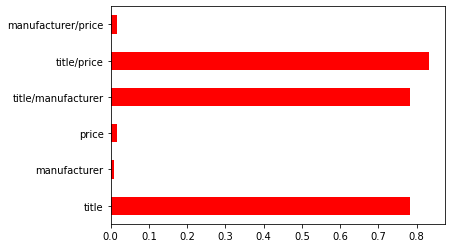

In [109]:
local_exp[0].plot.barh(color='red')